# Прогнозирование температуры звезды

## Описание проекта
**Задача от обсерватории «Небо на ладони»**: разработать нейросеть для определения температуры на поверхности обнаруженных звёзд.

### Цель проекта
Создать модель машинного обучения, которая будет предсказывать абсолютную температуру звезды на основе её характеристик.

---

## Традиционные методы расчёта температуры
Обычно учёные используют:
1. **Закон смещения Вина**
2. **Закон Стефана-Больцмана** 
3. **Спектральный анализ**

Каждый метод имеет преимущества и недостатки. ML-подход должен стать более точной и удобной альтернативой.

---

## Данные для обучения
В базе обсерватории есть характеристики **240 изученных звёзд**:

### Признаки звезды:
| Признак | Описание |
|---------|-----------|
| **Относительная светимость** | L/Lo - светимость звезды относительно Солнца |
| **Относительный радиус** | R/Ro - радиус звезды относительно радиуса Солнца |
| **Абсолютная звёздная величина** | Mv - физическая величина, характеризующая блеск звезды |
| **Звёздный цвет** | white, red, blue, yellow, yellow-orange и др. |
| **Тип звезды** | Категориальный признак |

### Типы звезд:
| Тип звезды | Числовой код |
|------------|--------------|
| Коричневый карлик | 0 |
| Красный карлик | 1 |
| Белый карлик | 2 |
| Звёзды главной последовательности | 3 |
| Сверхгигант | 4 |
| Гипергигант | 5 |

### Целевая переменная:
- **Абсолютная температура T(K)** - температура на поверхности звезды в Кельвинах

# Импортируем библиотеки

In [1]:
%%time
# здесь будем ставить все, чего нам не хватает
# !pip install missingno -q
# !pip install optuna -q
# !pip install tqdm -q
# !pip install seaborn -q
# !pip install torch -q
# !pip install scikit-learn -q
# !pip install statsmodels -q

CPU times: total: 0 ns
Wall time: 5.25 μs


In [2]:
import pandas as pd
import numpy as np
from IPython.display import HTML, display
import warnings
import logging
import os
from tqdm import tqdm

# === Библиотеки ML ===
from sklearn.model_selection import train_test_split
import torch.optim as optim
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import optuna
import random

# === Sklearn ===
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    FunctionTransformer,
)
from sklearn.feature_selection import SelectKBest, f_regression

# === Функции проекта ===
from func import (
    check_data,
    drop_duplicated,
    plot_combined,
    calc_target_correlations,
    plot_results,
    plot_categorical_columns,
    plot_scatter_with_numerical
)

# === Настройки ===
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings(
    "ignore",
    category=RuntimeWarning,
    module="sklearn.feature_selection._univariate_selection",
)
warnings.filterwarnings("ignore", category=UserWarning, module="shap")

logging.getLogger("sklearn").setLevel(logging.ERROR)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(name)s: %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)

e:\my_github\yandex_practicum_ds\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Константы

In [3]:
# зафиксируем константы
RANDOM_STATE = 20
TEST_SIZE = 0.25
N_ITER = 200
STD_EPOCH = 10000
EARLY_STOP = 200

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Загрузка данных

In [4]:
# df = pd.read_csv("../data/6_class.csv") # для локального запуска
df = pd.read_csv("https://code.s3.yandex.net/datasets/6_class.csv") # для облачного запуска
logger.info("Данные загружены")

2025-11-15 15:00:04 [INFO] __main__: Данные загружены


# Анализ и предобработка данных

In [5]:
df = check_data(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   unnamed:_0               240 non-null    int64  
 1   temperature_(_k)         240 non-null    int64  
 2   luminosity(_l/_lo)       240 non-null    float64
 3   radius(_r/_ro)           240 non-null    float64
 4   absolute_magnitude(_mv)  240 non-null    float64
 5   star_type                240 non-null    int64  
 6   star_color               240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.3+ KB


None

,unnamed:_0,temperature_(_k),luminosity(_l/_lo),radius(_r/_ro),absolute_magnitude(_mv),star_type,star_color
24,24,16500,0.01300,0.014,11.89,2,blue white
6,6,2637,0.00073,0.127,17.22,0,red
93,93,4980,0.35700,1.130,4.78,3,yellowish
109,109,33421,352000.00000,67.000,-5.79,4,blue
104,104,11096,112000.00000,12.000,-5.91,4,blue


Series([], dtype: int64)

None

,count,mean,std,min,25%,50%,75%,max
unnamed:_0,240.0,119.500000,69.426220,0.00000,59.750000,119.5000,179.2500,239.00
temperature_(_k),240.0,10497.462500,9552.425037,1939.00000,3344.250000,5776.0000,15055.5000,40000.00
luminosity(_l/_lo),240.0,107188.361635,179432.244940,0.00008,0.000865,0.0705,198050.0000,849420.00
radius(_r/_ro),240.0,237.157781,517.155763,0.00840,0.102750,0.7625,42.7500,1948.50
absolute_magnitude(_mv),240.0,4.382396,10.532512,-11.92000,-6.232500,8.3130,13.6975,20.06
star_type,240.0,2.500000,1.711394,0.00000,1.000000,2.5000,4.0000,5.00


In [6]:
# опять непонятный unnamed:_0 который дублирует индекс
df = df.drop(columns=['unnamed:_0'])

Пропусков нет, но есть цвет звезды - проверим

In [7]:
df['star_color'].unique()

array(['red', 'blue white', 'white', 'yellowish white',
       'pale yellow orange', 'blue', 'blue-white', 'whitish',
       'yellow-white', 'orange', 'white-yellow', 'yellowish',
       'orange-red'], dtype=object)

Так и оказалось, заполняли непонятно как... приведем неявные дубликаты к общему виду и немного наведем красоты

In [8]:
color_mapping = {
    # голубые
    'blue': 'blue',
    'blue-white': 'blue_white',
    'blue white': 'blue_white',

    # белые
    'white': 'white',
    'whitish': 'white',

    # жёлто-белые
    'white-yellow': 'white_yellow',
    'yellow-white': 'white_yellow',
    'yellowish white': 'white_yellow',

    # жёлтые
    'yellow': 'yellow',
    'yellowish': 'yellow',
    'pale yellow': 'yellow',

    # оранжевые
    'pale yellow orange': 'orange',
    'orange': 'orange',

    # красные
    'orange-red': 'red',
    'red-orange': 'red',
    'reddish': 'red',
    'red': 'red',
}

df['star_color'] = df['star_color'].str.strip().str.lower().replace(color_mapping)
df['star_color'].unique()

array(['red', 'blue_white', 'white', 'white_yellow', 'orange', 'blue',
       'yellow'], dtype=object)

In [9]:
df.sample(5)

,temperature_(_k),luminosity(_l/_lo),radius(_r/_ro),absolute_magnitude(_mv),star_type,star_color
58,3752,209000.00000,955.0000,-11.24,5,red
84,14100,0.00067,0.0089,12.17,2,blue_white
166,19923,152000.00000,73.0000,-5.69,4,blue
99,36108,198000.00000,10.2000,-4.40,3,blue
198,3324,0.00650,0.4710,12.78,1,red


Да, цвет звезды не совсем бьется с ее "цветовым типом", но в целом все логично.

In [10]:
# и теперь проверим явные дубликаты после корректировок
df = drop_duplicated(df)

np.int64(0)

'Дубликаты отсутствуют'

Посмотрим на распределение

2025-11-15 15:00:05 [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-15 15:00:05 [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


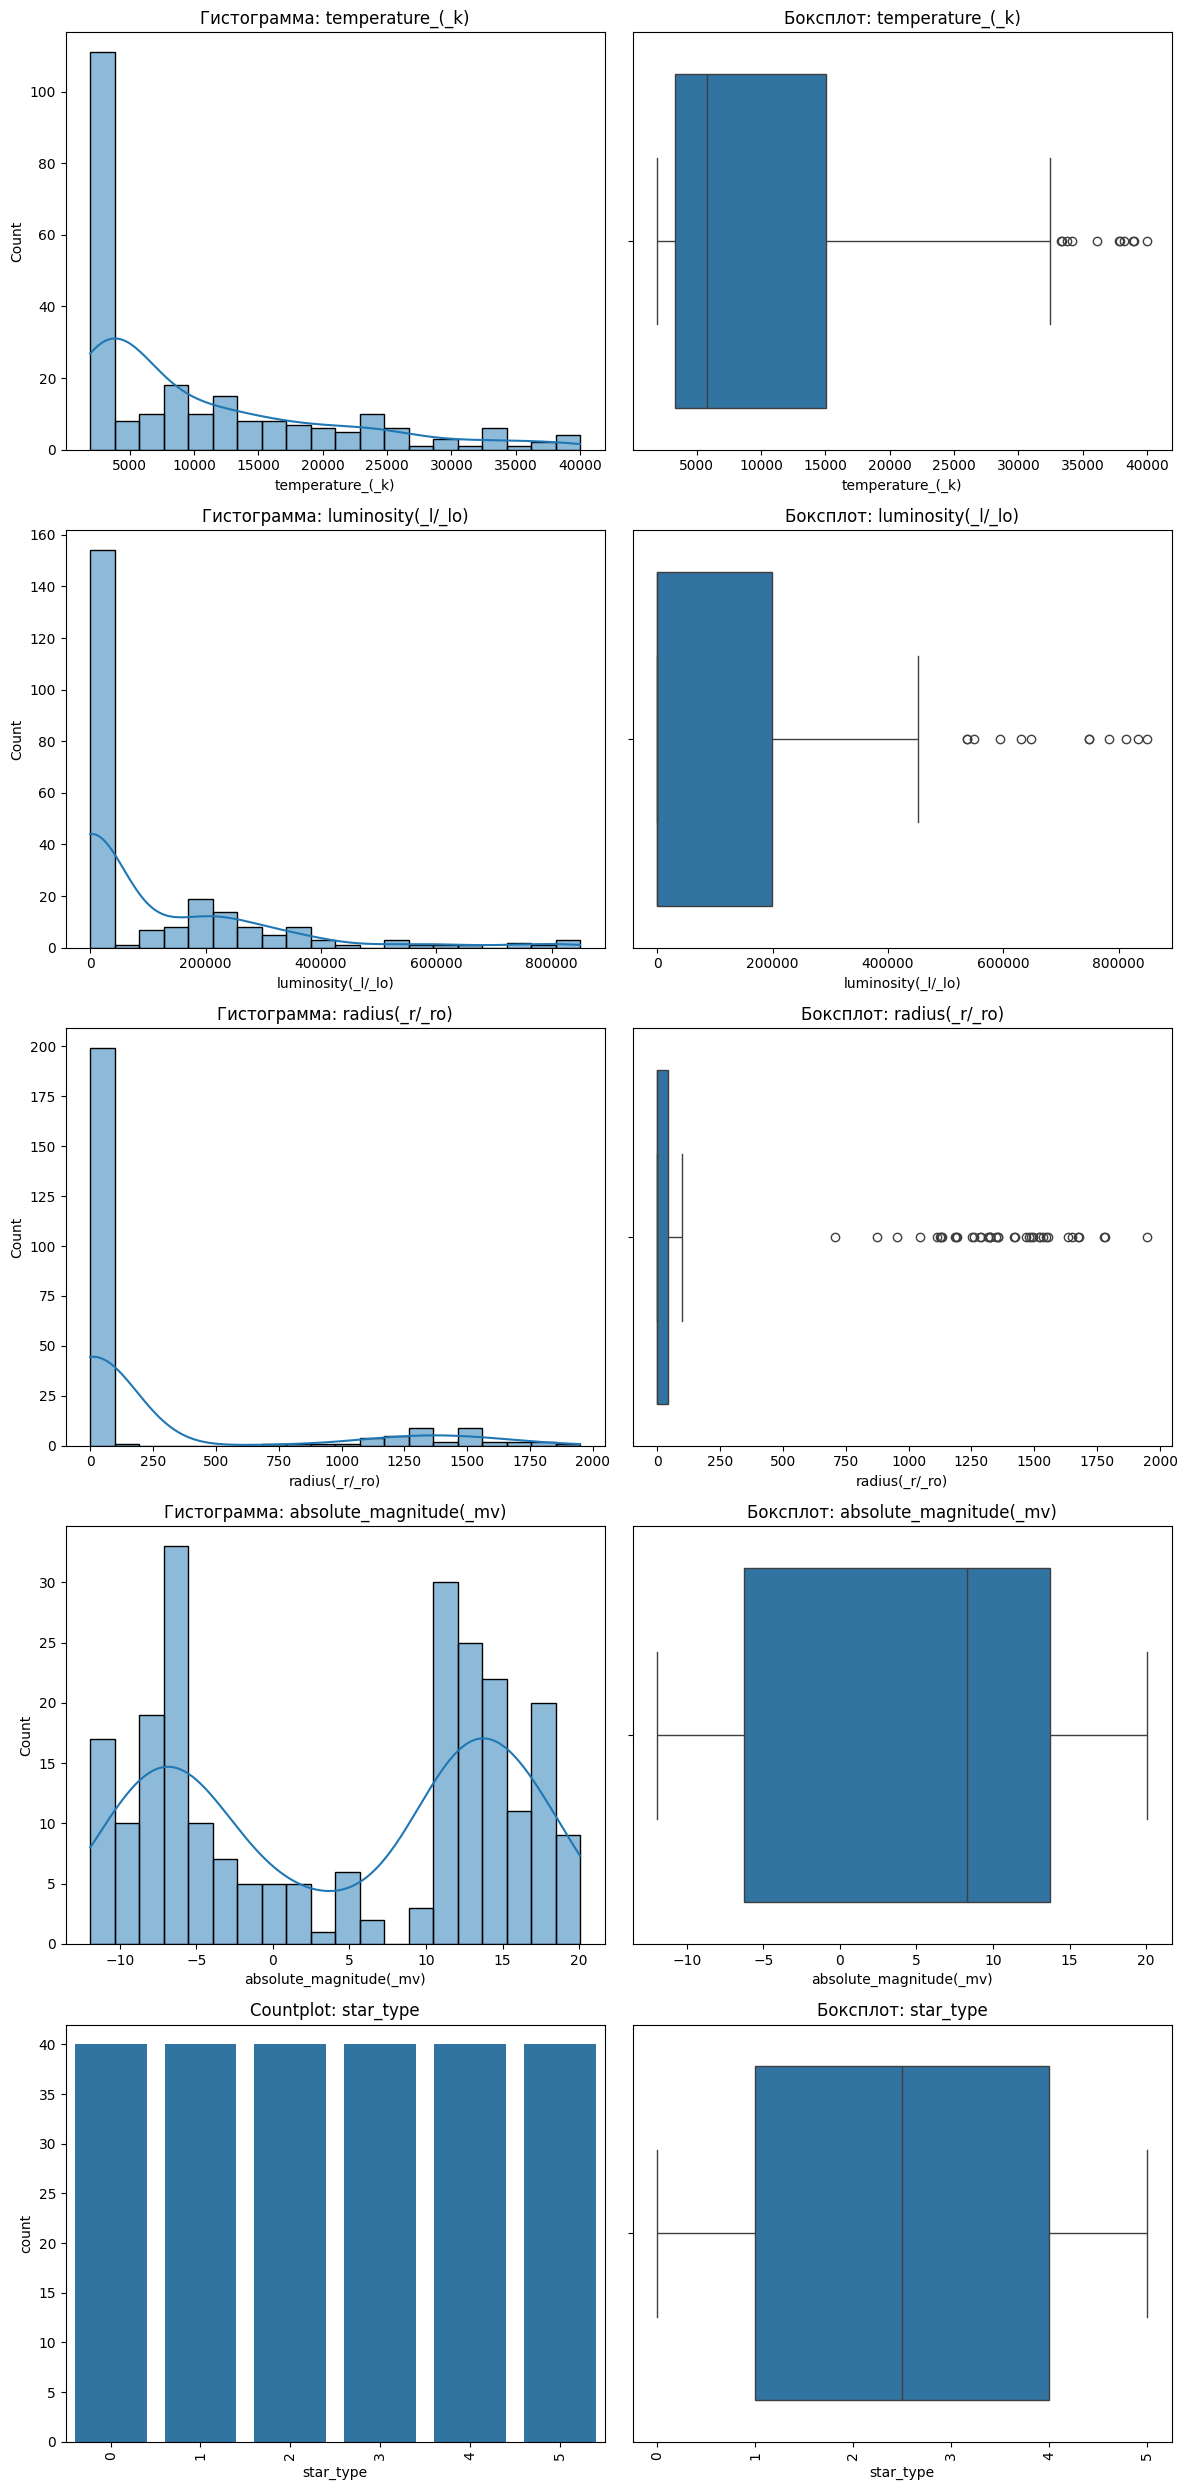

In [11]:
plot_combined(df, col=None, target=None, col_type=None, legend_loc='best')

Распределение по типу звёзд оказалось идеальным, прекрасно.  
А вот остальные признаки требуют дополнительного изучения и, наверное, обработки.

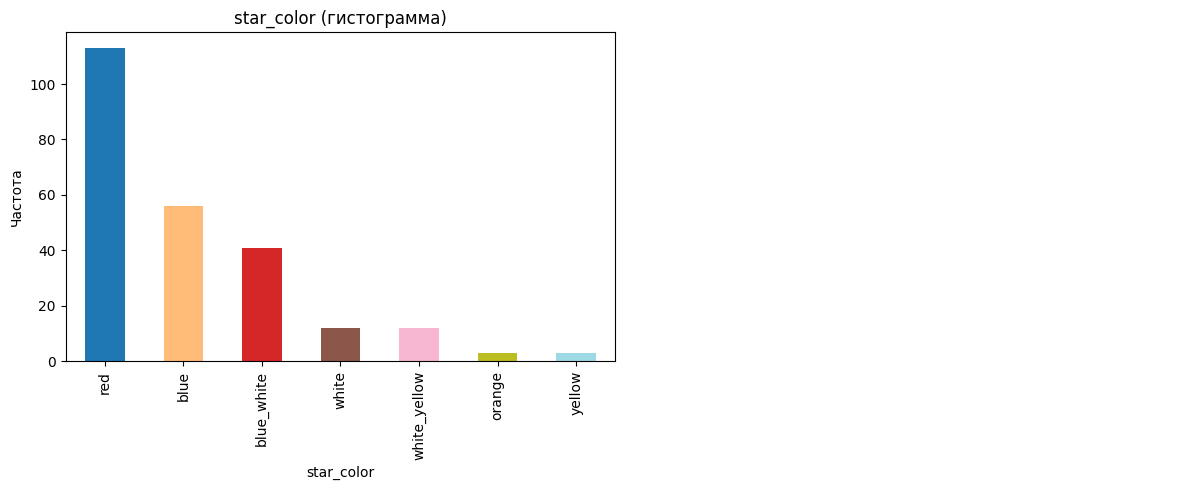

In [12]:
plot_categorical_columns(df, col=None, target=None)

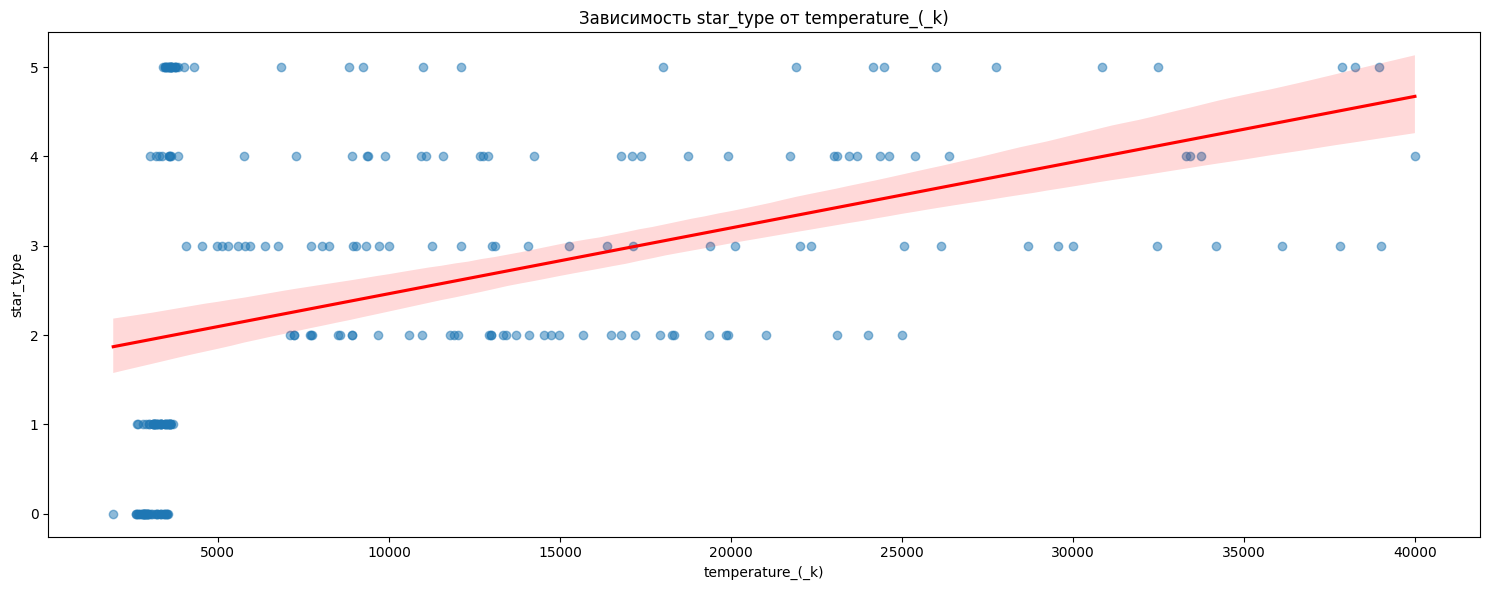

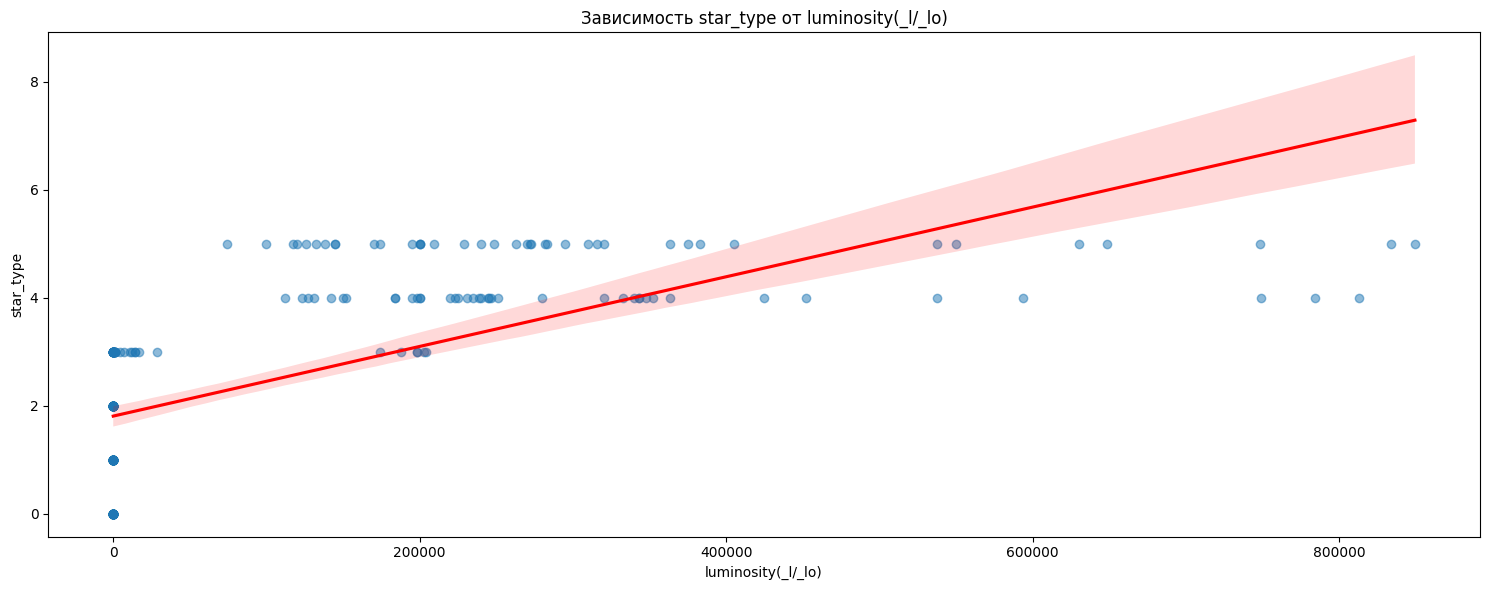

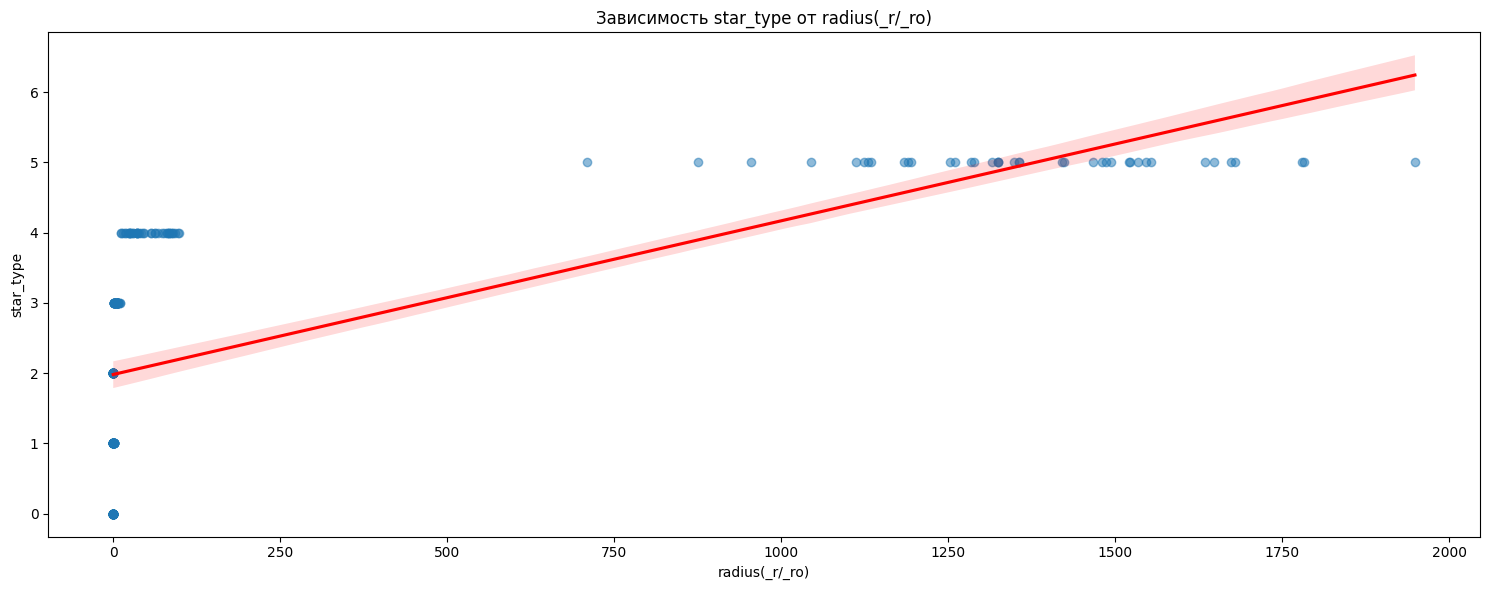

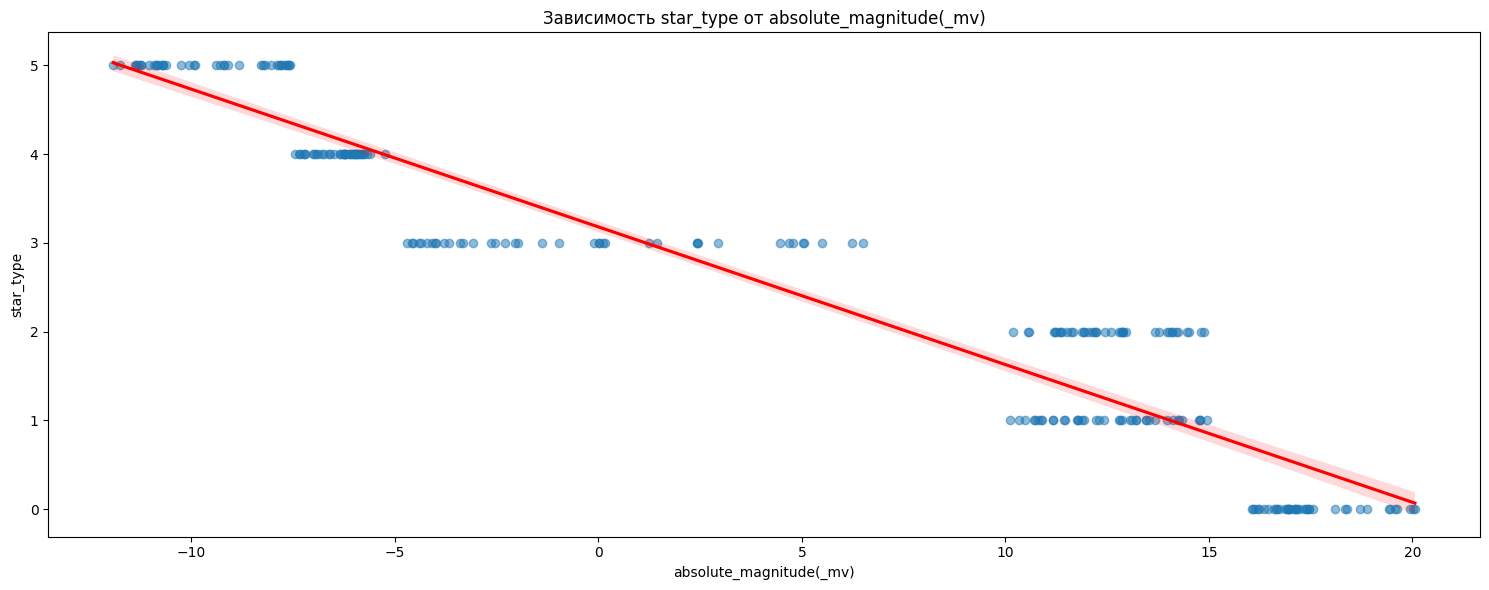

In [13]:
plot_scatter_with_numerical(df, target_column='star_type')

Инетересное наблюдение, чем выше Mv, тем "слабее" звезда.  
С остальными признаками все наоборот.  

In [14]:
# очень много данных temperature_(_k) меньше 5000, посмотрим на них отдельно
df_low_temp = df[df['temperature_(_k)'] < 2000]
df_low_temp

,temperature_(_k),luminosity(_l/_lo),radius(_r/_ro),absolute_magnitude(_mv),star_type,star_color
4,1939,0.000138,0.103,20.06,0,red


Нулевых нет и на том спасибо.  
К томуже справочный материал говорит, что такая температура вполне возможна.

In [15]:
# и выбросы по высокой температуре
df_high_temp = df[df['temperature_(_k)'] > 35000]
df_high_temp

,temperature_(_k),luminosity(_l/_lo),radius(_r/_ro),absolute_magnitude(_mv),star_type,star_color
30,39000,204000.0,10.60,-4.70,3,blue
99,36108,198000.0,10.20,-4.40,3,blue
101,40000,813000.0,14.00,-6.23,4,blue
159,37800,202900.0,6.86,-4.56,3,blue
231,38234,272830.0,1356.00,-9.29,5,blue
235,38940,374830.0,1356.00,-9.93,5,blue
239,37882,294903.0,1783.00,-7.80,5,blue


Вопросики по светимости к типу 4 да и в целом все еще непонятно определение цвета звезд.  
Разные типы, разные размеры, разные светимости....  
Ничего непонятно, но очень интересно :)

Теперь свечение luminosity(_l/_lo)

In [16]:
df_low_lum = df[df['luminosity(_l/_lo)'] < 100]
df_low_lum

,temperature_(_k),luminosity(_l/_lo),radius(_r/_ro),absolute_magnitude(_mv),star_type,star_color
0,3068,0.002400,0.17000,16.120,0,red
1,3042,0.000500,0.15420,16.600,0,red
2,2600,0.000300,0.10200,18.700,0,red
3,2800,0.000200,0.16000,16.650,0,red
4,1939,0.000138,0.10300,20.060,0,red
...,...,...,...,...,...,...
207,23092,0.001320,0.01040,10.180,2,blue
208,17920,0.001110,0.01060,11.660,2,blue
209,19360,0.001250,0.00998,11.620,2,blue
216,9320,29.000000,1.91000,1.236,3,blue_white


In [17]:
df_low_lum = df[df['luminosity(_l/_lo)'] > 500000]
df_low_lum

,temperature_(_k),luminosity(_l/_lo),radius(_r/_ro),absolute_magnitude(_mv),star_type,star_color
53,3749,550000.0,1648.0,-8.050,5,orange
101,40000,813000.0,14.0,-6.230,4,blue
172,4287,630000.0,1315.0,-9.200,5,orange
223,23440,537430.0,81.0,-5.975,4,blue
226,9892,593900.0,80.0,-7.262,4,blue
227,10930,783930.0,25.0,-6.224,4,blue
229,21738,748890.0,92.0,-7.346,4,blue
232,32489,648430.0,1948.5,-10.840,5,blue
233,27739,849420.0,1252.0,-7.590,5,blue_white
234,21904,748490.0,1130.0,-7.670,5,blue_white


Вот о чем и писал выше - светимость огромная, а температура может быть не очень высокой.

Так как у нас идет сравнение с Солнцем, что оставим как есть.  

Радиус radius(_r/_ro) скорее всего покажет схожую картину, но посмотрим.

In [18]:
df_low_rad = df[df['radius(_r/_ro)'] < 100]
df_low_rad

,temperature_(_k),luminosity(_l/_lo),radius(_r/_ro),absolute_magnitude(_mv),star_type,star_color
0,3068,0.002400,0.1700,16.120,0,red
1,3042,0.000500,0.1542,16.600,0,red
2,2600,0.000300,0.1020,18.700,0,red
3,2800,0.000200,0.1600,16.650,0,red
4,1939,0.000138,0.1030,20.060,0,red
...,...,...,...,...,...,...
225,18734,224780.000000,46.0000,-7.450,4,blue
226,9892,593900.000000,80.0000,-7.262,4,blue
227,10930,783930.000000,25.0000,-6.224,4,blue
228,23095,347820.000000,86.0000,-5.905,4,blue


In [19]:
df_low_rad = df[df['radius(_r/_ro)'] > 200]
df_low_rad

,temperature_(_k),luminosity(_l/_lo),radius(_r/_ro),absolute_magnitude(_mv),star_type,star_color
50,3490,270000.0,1520.0,-9.40,5,red
51,3750,283000.0,1260.0,-7.63,5,red
52,3834,272000.0,1183.0,-9.20,5,red
53,3749,550000.0,1648.0,-8.05,5,orange
54,3650,310000.0,1324.0,-7.79,5,red
55,3450,263000.0,1349.0,-11.75,5,red
56,3660,363000.0,1673.0,-11.92,5,red
57,3450,174000.0,1284.0,-11.28,5,red
58,3752,209000.0,955.0,-11.24,5,red
59,3535,195000.0,1546.0,-11.36,5,red


'=== Корреляция с таргетом ==='

star_color                -0.716105
absolute_magnitude(_mv)   -0.420261
star_type                  0.411129
luminosity(_l/_lo)         0.393404
radius(_r/_ro)             0.064216
Name: temperature_(_k), dtype: float64

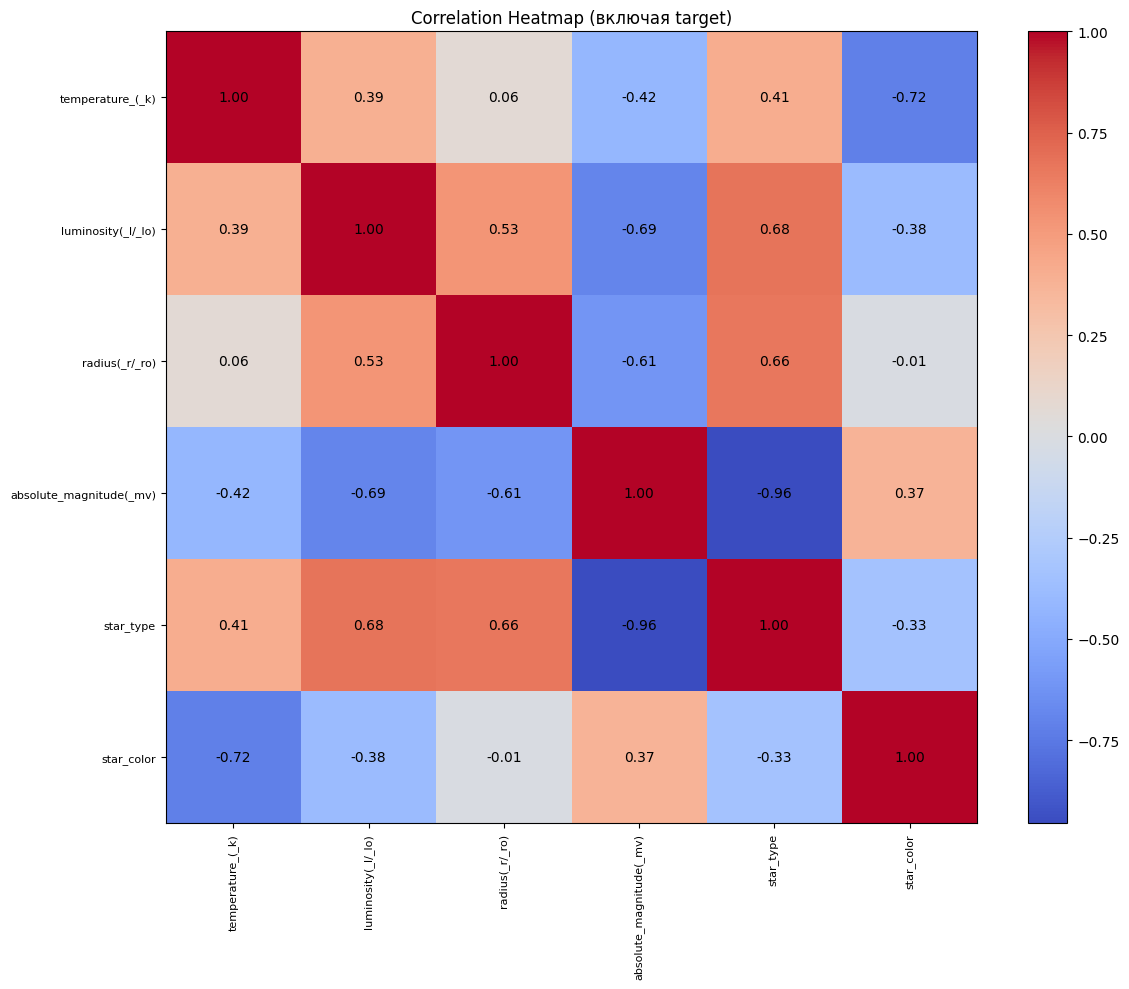

'=== VIF ==='

,feature,VIF
2,absolute_magnitude(_mv),9.054719
3,star_type,5.860382
0,luminosity(_l/_lo),2.819748
1,radius(_r/_ro),2.072296
4,star_color,1.665016


In [20]:
calc_target_correlations(df, target_col="temperature_(_k)")

Мультиколлинеарности не наблюдается.  
VIF в пределах допустимого.

## Выводы по анализу данных

**Основные проблемы в данных о звездах**  

*Несоответствие температуры и цвета*  
- Холодные звезды указаны с цветами, характерными для горячих звезд  
- Нарушена физическая связь между температурой и спектральным классом  

*Нарушение астрофизических законов*  
- Не соблюдается закон Стефана-Больцмана (связь светимости с радиусом и температурой)  
- Параметры светимости и радиуса противоречат друг другу  

*Статистические аномалии*  
- Слишком много редких типов звезд (гипергигантов)  
- Нарушены реальные пропорции встречаемости разных классов звезд  

*Проблемы с классификацией*  
- Цвета звезд не соответствуют их физическим параметрам  
- Отсутствует системный подход к классификации по спектральным классам  
- Произвольное сочетание характеристик без физического обоснования  

*Методологические проблемы*  
- Данные выглядят сгенерированными, а не наблюдаемыми  
- Отсутствует внутренняя согласованность параметров  
- Нарушены известные астрофизические зависимости  

В целом: Данные требуют серьезной доработки для соответствия реальным астрономическим закономерностям.  
Но ввиду того, что это учебный проект, будем работать с тем, что есть.  

# Построение базовой нейронной сети

## Разделение данных на признаки и целевой признак

In [21]:
# разделим на выборки их оставшихся данных
target = 'temperature_(_k)'
X_train, X_test, y_train, y_test = train_test_split(
    df.drop([target], axis=1),
    df[target],
    shuffle=True,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=df['star_color']
)

In [22]:
# разделяем признаки с учетом ordinal переменной
def custom_selector(X):
    """Для разделения признаков"""
    cat_cols = []
    ord_cols = ['star_type']
    num_cols = []
    
    for col in X.columns:
        if col in ord_cols:
            continue
        elif X[col].dtype in ['object', 'category']:
            cat_cols.append(col)
        else:
            num_cols.append(col)
    
    return num_cols, cat_cols, ord_cols

num_cols, cat_cols, ord_cols = custom_selector(X_train)

display("Числовые:", num_cols)
display("Категориальные (nominal):", cat_cols)
display("Порядковые (ordinal):", ord_cols)

'Числовые:'

['luminosity(_l/_lo)', 'radius(_r/_ro)', 'absolute_magnitude(_mv)']

'Категориальные (nominal):'

['star_color']

'Порядковые (ordinal):'

['star_type']

In [23]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("scaler", StandardScaler())
        ]), num_cols),
        ("cat", Pipeline([
            ("to_str", FunctionTransformer(lambda x: x.astype(str))),
            ("encoder", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False))
        ]), cat_cols),
        ("ord", Pipeline([
            ("encoder", OrdinalEncoder())
        ]), ord_cols)
    ]
)

In [24]:
preprocessing_pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

preprocessing_pipeline.fit(X_train)

X_train_processed = preprocessing_pipeline.transform(X_train)
X_test_processed = preprocessing_pipeline.transform(X_test)

# посмотри как все нормализовалось после пайплайна
cat_encoder = preprocessing_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
cat_feature_names = cat_encoder.get_feature_names_out(cat_cols)

feature_names = (
    list(num_cols)
    + list(cat_feature_names)
    + list(ord_cols)
)

X_train_transformed_df = pd.DataFrame(X_train_processed, columns=feature_names)
display(X_train_transformed_df.sample(10))

,luminosity(_l/_lo),radius(_r/_ro),absolute_magnitude(_mv),star_color_blue_white,star_color_orange,star_color_red,star_color_white,star_color_white_yellow,star_color_yellow,star_type
86,0.070453,1.646898,-1.422573,0.0,0.0,1.0,0.0,0.0,0.0,5.0
67,0.399703,-0.457586,-0.782551,1.0,0.0,0.0,0.0,0.0,0.0,3.0
153,-0.598670,-0.468260,0.718676,0.0,0.0,1.0,0.0,0.0,0.0,1.0
116,-0.598670,-0.468405,0.752559,0.0,0.0,1.0,0.0,0.0,0.0,1.0
87,0.675849,1.771136,-1.147740,0.0,0.0,1.0,0.0,0.0,0.0,5.0
138,-0.598670,-0.468733,1.226928,0.0,0.0,1.0,0.0,0.0,0.0,0.0
31,2.555235,-0.318327,-1.088632,0.0,0.0,0.0,0.0,0.0,0.0,4.0
40,-0.598670,-0.468371,0.619849,0.0,0.0,1.0,0.0,0.0,0.0,1.0
46,-0.598670,-0.467657,0.881222,0.0,0.0,1.0,0.0,0.0,0.0,1.0
62,-0.598670,-0.468901,0.726205,0.0,0.0,0.0,1.0,0.0,0.0,2.0


In [25]:
# все отлично
# конвертируем в тензоры
X_train_tensor = torch.FloatTensor(X_train_processed)
X_test_tensor = torch.FloatTensor(X_test_processed)
y_train_tensor = torch.FloatTensor(y_train.values)
y_test_tensor = torch.FloatTensor(y_test.values)

In [26]:
display(preprocessing_pipeline)

,steps,"[('preprocessor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# Построение простой модели нейронной сети — baseline

## Создаем класс для задания архитектуры нейронной сети

baseline сделаю самый простой, чтобы потом было с чем сравнивать  
Несколько скрытых слоев, немного нейронов и функции активации и потерь наиболее распространенные и поддходящие для задачи

In [27]:
class StarTemperatureNet(nn.Module):
    def __init__(self, input_size):
        super(StarTemperatureNet, self).__init__()
        self.layer1 = nn.Linear(input_size, 256)
        self.layer2 = nn.Linear(256, 512)
        self.layer3 = nn.Linear(512, 512)
        self.layer4 = nn.Linear(512, 512)
        self.layer5 = nn.Linear(512, 64)
        self.layer6 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.relu(self.layer4(x))
        x = self.relu(self.layer5(x))
        x = self.layer6(x)
        return x

def train_model(model, X_train, y_train, X_test, y_test,
                epochs=5000, lr=1e-3, weight_decay=1e-5, batch_size=None):
    
    # Если batch_size не указан, используем всю обучающую выборку
    if batch_size is None:
        batch_size = X_train.size(0)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50)

    train_losses, test_losses = [], []

    n_samples = X_train.size(0)
    n_batches = max(1, (n_samples + batch_size - 1) // batch_size)  # минимум 1 батч

    logger.info(f"Размер батча: {batch_size}, всего батчей: {n_batches}")

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0

        # Если батч = вся выборка, не нужно перемешивать индексы
        if batch_size == n_samples:
            # Один большой батч - вся выборка
            batch_x, batch_y = X_train, y_train.unsqueeze(1)
            
            optimizer.zero_grad()
            preds = model(batch_x)
            loss = criterion(preds, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss = loss.item()
            
        else:
            # Мини-батчи с перемешиванием
            perm = torch.randperm(n_samples)
            for i in range(n_batches):
                idx = perm[i*batch_size:(i+1)*batch_size]
                batch_x, batch_y = X_train[idx], y_train[idx].unsqueeze(1)

                optimizer.zero_grad()
                preds = model(batch_x)
                loss = criterion(preds, batch_y)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

        model.eval()
        with torch.no_grad():
            test_preds = model(X_test)
            test_mse = criterion(test_preds, y_test.unsqueeze(1))
            test_rmse = torch.sqrt(test_mse).item()

        train_rmse = np.sqrt(epoch_loss / n_batches)
        train_losses.append(train_rmse)
        test_losses.append(test_rmse)

        scheduler.step(test_rmse)

        if epoch % 200 == 0:
            logger.info(f"Эпоха {epoch}, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

    return train_losses, test_losses

# Использование с полным батчем
input_size = X_train_tensor.shape[1]
model = StarTemperatureNet(input_size=input_size)
logger.info(f"Размер входных данных: {input_size}")
logger.info(f"Размер обучающей выборки: {X_train_tensor.size(0)}")
logger.info(model)
logger.info(f"Всего параметров: {sum(p.numel() for p in model.parameters())}")

train_losses, test_losses = train_model(
    model,
    X_train_tensor,
    y_train_tensor,
    X_test_tensor,
    y_test_tensor,
    batch_size=None,
    epochs=1000
)

2025-11-15 15:00:07 [INFO] __main__: Размер входных данных: 10
2025-11-15 15:00:07 [INFO] __main__: Размер обучающей выборки: 180
2025-11-15 15:00:07 [INFO] __main__: StarTemperatureNet(
  (layer1): Linear(in_features=10, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=512, bias=True)
  (layer3): Linear(in_features=512, out_features=512, bias=True)
  (layer4): Linear(in_features=512, out_features=512, bias=True)
  (layer5): Linear(in_features=512, out_features=64, bias=True)
  (layer6): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)
2025-11-15 15:00:07 [INFO] __main__: Всего параметров: 692609
2025-11-15 15:00:08 [INFO] __main__: Размер батча: 180, всего батчей: 1
2025-11-15 15:00:09 [INFO] __main__: Эпоха 0, Train RMSE: 14813.4193, Test RMSE: 12080.6396
2025-11-15 15:00:10 [INFO] __main__: Эпоха 200, Train RMSE: 4373.5601, Test RMSE: 5778.3862
2025-11-15 15:00:11 [INFO] __main__: Эпоха 400, Train RMSE: 3049.2335, Test RMSE: 4969.6328

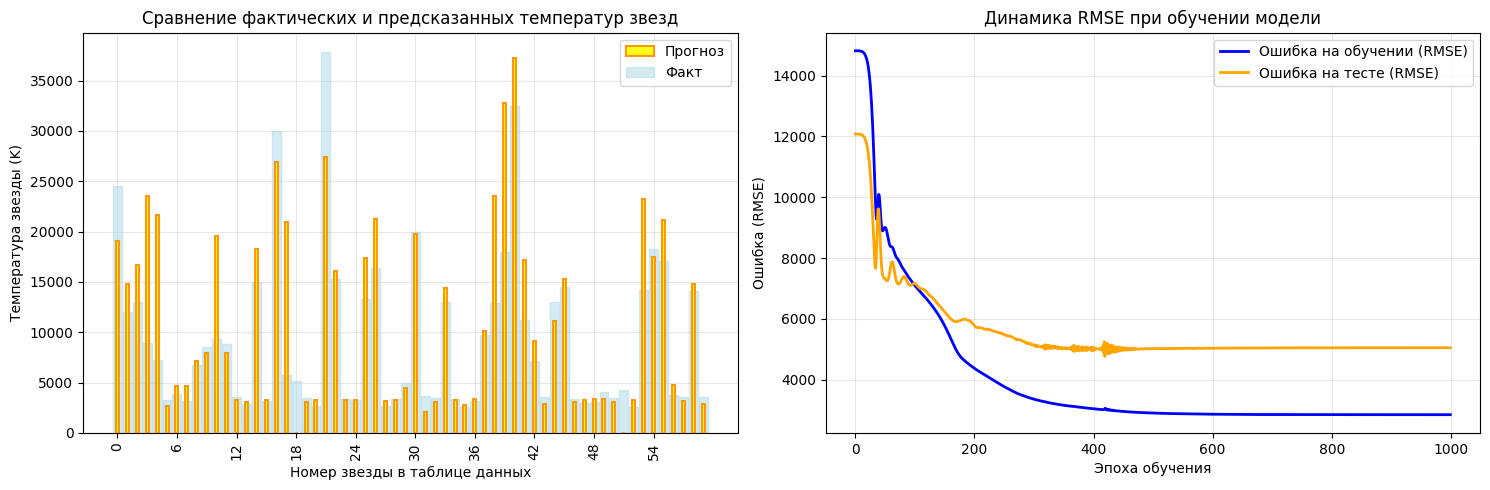

2025-11-15 15:00:15 [INFO] func: Средняя абсолютная ошибка (MAE): 2914.92 K
2025-11-15 15:00:15 [INFO] func: Среднеквадратичная ошибка (RMSE): 5053.01 K
2025-11-15 15:00:15 [INFO] func: Коэффициент детерминации (R²): 0.5844
2025-11-15 15:00:15 [INFO] func: Средняя температура: 9192.53 K
2025-11-15 15:00:15 [INFO] func: Стандартное отклонение: 7838.52 K
2025-11-15 15:00:15 [INFO] func: 
Первые 10 предсказаний:


,luminosity(_l/_lo),radius(_r/_ro),absolute_magnitude(_mv),star_type,star_color,actual_temperature,predicted_temperature,absolute_error
0,248490.00000,1134.50000,-8.24,5,blue_white,24490.0,19029.623047,5460.376953
1,0.00078,0.00920,12.13,2,blue_white,12010.0,14828.028320,2818.028320
2,0.00088,0.00996,11.23,2,blue_white,12984.0,16676.744141,3692.744141
3,239000.00000,35.00000,-7.34,4,blue,8927.0,23519.228516,14592.228516
4,131000.00000,24.00000,-7.22,4,blue,7282.0,21698.035156,14416.035156
5,0.00076,0.12100,19.63,0,red,3225.0,2686.959229,538.040771
6,272000.00000,1183.00000,-9.20,5,red,3834.0,4632.375488,798.375488
7,195000.00000,17.00000,-7.22,4,red,3200.0,4619.890625,1419.890625
8,1.43000,1.12000,2.41,3,white_yellow,6757.0,7102.778320,345.778320
9,0.00050,0.01000,14.50,2,white,8500.0,7982.161621,517.838379


2025-11-15 15:00:15 [INFO] func: 
Статистика по ошибкам предсказания:


count       60.000000
mean      2914.920166
std       4162.315430
min         39.769775
25%        390.039246
50%        768.735107
75%       4003.982910
max      15245.748047
Name: absolute_error, dtype: float64

In [28]:
mae, rmse, r2, df_pred = plot_results(
    model, 
    X_test_tensor, 
    y_test_tensor, 
    train_losses, 
    test_losses,
    X_test_original=X_test
)

Послее 1000 эпох, при любых параметрах, что я попробовал - модель выходит на плато и дальше не улучшается.  
И в ручную особо не получается достичь требуемой точности.

Вот такой получился baseline вариант модели нейронной сети.  
Модель работает, модель что-то даже считает и что-то даже предсказывает.  
Но пока что качество оставляет желать лучшего, к тому же она явно переобучилась без использования ранней остановки.  
Перейдем более углубленному и осознанному подбору гиперпараметров и архитектуры модели.  

# Улучшение нейронной сети

А теперь попробуем улучшить нашу модель.  

In [29]:
# сделаем класс
class StarTemperatureNetFixed(nn.Module):
    def __init__(self, input_size, dropout_rate=0.0):
        super().__init__()
        self.layer1 = nn.Linear(input_size, 256)
        self.layer2 = nn.Linear(256, 512)
        self.layer3 = nn.Linear(512, 512)
        self.layer4 = nn.Linear(512, 512)
        self.layer5 = nn.Linear(512, 64)
        self.layer6 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout_rate = dropout_rate
        if dropout_rate > 0:
            self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        if self.dropout_rate > 0: x = self.dropout(x)
        x = self.relu(self.layer2(x))
        if self.dropout_rate > 0: x = self.dropout(x)
        x = self.relu(self.layer3(x))
        if self.dropout_rate > 0: x = self.dropout(x)
        x = self.relu(self.layer4(x))
        if self.dropout_rate > 0: x = self.dropout(x)
        x = self.relu(self.layer5(x))
        if self.dropout_rate > 0: x = self.dropout(x)
        x = self.layer6(x)
        return x

In [30]:
# вместо функции ошибки будем использовать RMSE с отслеживанием лучшей модели
def train_model_with_tracking(model, X_train, y_train, X_test, y_test,
                                    epochs=2000, lr=1e-3, patience=200, weight_decay=1e-5,
                                    batch_size=64, optimizer_type='Adam', scheduler_params=None,
                                    device='cpu'):
    
    if scheduler_params is None:
        scheduler_params = {"factor": 0.5, "patience": 20}

    model.to(device)
    X_train, y_train = X_train.to(device), y_train.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)

    criterion = nn.MSELoss()

    # выбор оптимизатора
    if optimizer_type == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_type == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=scheduler_params["patience"], 
                                                     factor=scheduler_params["factor"])

    best_rmse, patience_counter, best_state = float('inf'), 0, None
    train_losses, test_losses = [], []

    n_samples = X_train.size(0)
    n_batches = (n_samples + batch_size - 1) // batch_size

    for epoch in range(epochs):
        model.train()
        perm = torch.randperm(n_samples)
        epoch_loss = 0.0

        for i in range(n_batches):
            idx = perm[i*batch_size:(i+1)*batch_size]
            batch_x, batch_y = X_train[idx], y_train[idx].unsqueeze(1)

            optimizer.zero_grad()
            preds = model(batch_x)
            loss = criterion(preds, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        model.eval()
        with torch.no_grad():
            preds_test = model(X_test)
            test_rmse = np.sqrt(criterion(preds_test, y_test.unsqueeze(1)).item())

        train_rmse = np.sqrt(epoch_loss / n_batches)
        train_losses.append(train_rmse)
        test_losses.append(test_rmse)

        if test_rmse < best_rmse:
            best_rmse, patience_counter = test_rmse, 0
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            patience_counter += 1
            if patience_counter >= patience:
                # logger.info(f"Ранняя остановка на эпохе {epoch}, лучший RMSE={best_rmse:.6f}")
                break

        # if epoch % 2000 == 0:
        #     logger.info(f"Эпоха {epoch}, RMSE на тесте = {test_rmse:.6f}")

        scheduler.step(test_rmse)

    if best_state:
        model.load_state_dict(best_state)
        model.to(device)

    return best_rmse, model, train_losses, test_losses

In [31]:
# подбирать буду через Optuna которая себя хорошо зарекомендовала в прошлых проектах и давала хорошие результаты
# подготовим objective функцию и сетку гиперпараметров для оптимизации
def objective(trial):
    X_train_np = X_train_tensor.cpu().numpy()
    X_test_np = X_test_tensor.cpu().numpy()
    y_train_np = y_train_tensor.cpu().numpy().ravel()

    n_features = X_train_np.shape[1]
    k_features = trial.suggest_int("k_features", 2, n_features)

    selector = SelectKBest(f_regression, k=k_features)
    X_train_sel = selector.fit_transform(X_train_np, y_train_np)
    X_test_sel = selector.transform(X_test_np)

    X_train_sel_t = torch.tensor(X_train_sel, dtype=torch.float32).to(device)
    X_test_sel_t = torch.tensor(X_test_sel, dtype=torch.float32).to(device)
    y_train_t, y_test_t = y_train_tensor.clone(), y_test_tensor.clone()

    # Зафиксированная архитектура как в baseline модели
    hidden_sizes = [256, 512, 512, 512, 64]
    activation = 'relu'

    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    optimizer_type = trial.suggest_categorical('optimizer', ['Adam', 'AdamW', 'RMSprop'])
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256, 512])

    scheduler_params = {
        "factor": trial.suggest_float("lr_factor", 0.3, 0.8),
        "patience": trial.suggest_int("lr_patience", 10, 50)
    }

    model = StarTemperatureNetFixed(
        X_train_sel.shape[1], dropout_rate
    )

    best_rmse, _, train_losses, test_losses = train_model_with_tracking(
        model,
        X_train_sel_t, y_train_t, X_test_sel_t, y_test_t,
        epochs=STD_EPOCH, lr=learning_rate, patience=EARLY_STOP,
        weight_decay=weight_decay, device=device,
        optimizer_type=optimizer_type, scheduler_params=scheduler_params,
        batch_size=batch_size
    )

    trial.set_user_attr("k_features", k_features)
    trial.set_user_attr("batch_size", batch_size)

    return best_rmse


In [32]:
# и сделаем функцию для запуска оптимизации и сбора результатов в таблицу
def run_optuna_and_report(X_train_t, y_train_t, X_test_t, y_test_t, n_trials=30):
    global X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor
    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = X_train_t, y_train_t, X_test_t, y_test_t

    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction='minimize')

    # tqdm по триалам
    for _ in tqdm(range(n_trials), desc="Оптуна (триалы)"):
        study.optimize(objective, n_trials=1)

    rows = []
    for t in study.trials:
        if t.value is None:
            continue
        r = dict(t.params)
        hidden = [r[k] for k in sorted([k for k in r.keys() if k.startswith('n_units_l')],
                                       key=lambda x: int(x.split('l')[-1]))]
        r['hidden_sizes'] = hidden
        r['k_features'] = t.user_attrs.get('k_features')
        r['rmse'] = t.value
        rows.append(r)

    df_results = pd.DataFrame(rows).sort_values('rmse').reset_index(drop=True)
    df_results.to_csv('../result/optuna_trials_results.csv', index=False)
    logger.info("Результаты экспериментов сохранены в ../result/optuna_trials_results.csv")
    logger.info(f"Лучший RMSE: {study.best_value:.6f}")
    logger.info(f"Лучшие параметры: {study.best_params}")

    return study, df_results

In [33]:
# после всех экспериментов мы получили лучшие показатели гиперпараметров, на который сейчас и обучим модель с последующим сохранением и визуализацией
def train_and_plot_best(study, X_train_t, y_train_t, X_test_t, y_test_t, X_test_original=None):
    best_params = study.best_params
    hidden_sizes = [best_params[k] for k in sorted([k for k in best_params.keys() if k.startswith('n_units_l')],
                                                   key=lambda x: int(x.split('l')[-1]))]
    k_features = study.best_trial.user_attrs['k_features']

    optimizer_type = best_params.get('optimizer', 'Adam')
    scheduler_params = {
        "factor": best_params.get('lr_factor', 0.5),
        "patience": best_params.get('lr_patience', 20)
    }

    X_train_np, X_test_np, y_train_np = X_train_t.cpu().numpy(), X_test_t.cpu().numpy(), y_train_t.cpu().numpy().ravel()
    selector = SelectKBest(f_regression, k=k_features)
    X_train_sel = selector.fit_transform(X_train_np, y_train_np)
    X_test_sel = selector.transform(X_test_np)

    X_train_sel_t = torch.tensor(X_train_sel, dtype=torch.float32).to(device)
    X_test_sel_t = torch.tensor(X_test_sel, dtype=torch.float32).to(device)
    y_train_t = y_train_t.to(device)
    y_test_t = y_test_t.to(device)

    model = StarTemperatureNetFixed(X_train_sel.shape[1],
                                       dropout_rate=best_params['dropout_rate'])

    best_rmse, trained_model, train_losses, test_losses = train_model_with_tracking(
        model, X_train_sel_t, y_train_t, X_test_sel_t, y_test_t,
        epochs=STD_EPOCH, 
        lr=best_params['learning_rate'], 
        patience=EARLY_STOP, 
        weight_decay=best_params['weight_decay'],
        device=device,
        optimizer_type=optimizer_type,
        scheduler_params=scheduler_params
    )

    mae, rmse, r2, df_pred = plot_results(
        trained_model, X_test_sel_t, y_test_t, train_losses, test_losses, X_test_original
    )

    logger.info(f"Лучший RMSE после оптуны: {study.best_value:.6f}")
    logger.info(f"Финальный RMSE: {rmse:.6f}")
    logger.info(f"MAE: {mae:.6f}, R²: {r2:.6f}")

    logger.info(f"Использованный оптимизатор: {optimizer_type}")
    logger.info(f"Использован планировщик: factor={scheduler_params['factor']}, patience={scheduler_params['patience']}")

    if abs(rmse - study.best_value) / study.best_value < 0.1:
        logger.info("Результаты финального обучения близки к лучшим результатам Optuna")
    else:
        logger.info("Результаты финального обучения отличаются от лучших результатов Optuna")

    torch.save(trained_model.state_dict(), 'best_model.pth')
    logger.info("Лучшая модель сохранена в best_model.pth")

    return trained_model, mae, rmse, r2, df_pred

2025-11-15 15:00:15 [INFO] __main__: Используется: cuda
Оптуна (триалы): 100%|██████████| 200/200 [39:32<00:00, 11.86s/it]
2025-11-15 15:39:48 [INFO] __main__: Результаты экспериментов сохранены в ../result/optuna_trials_results.csv
2025-11-15 15:39:48 [INFO] __main__: Лучший RMSE: 3227.766255
2025-11-15 15:39:48 [INFO] __main__: Лучшие параметры: {'k_features': 10, 'dropout_rate': 0.23160090045133663, 'learning_rate': 0.00223141716139872, 'weight_decay': 5.076593420545737e-05, 'optimizer': 'RMSprop', 'batch_size': 16, 'lr_factor': 0.5079940775579606, 'lr_patience': 48}
2025-11-15 15:39:48 [INFO] __main__: 
=== Лучший результат ===
2025-11-15 15:39:48 [INFO] __main__: Лучший RMSE: 3227.766255
2025-11-15 15:39:48 [INFO] __main__:   k_features: 10
2025-11-15 15:39:48 [INFO] __main__:   dropout_rate: 0.2316009004513366
2025-11-15 15:39:48 [INFO] __main__:   learning_rate: 0.0022314171613987
2025-11-15 15:39:48 [INFO] __main__:   weight_decay: 5.076593420545737e-05
2025-11-15 15:39:48 [INF

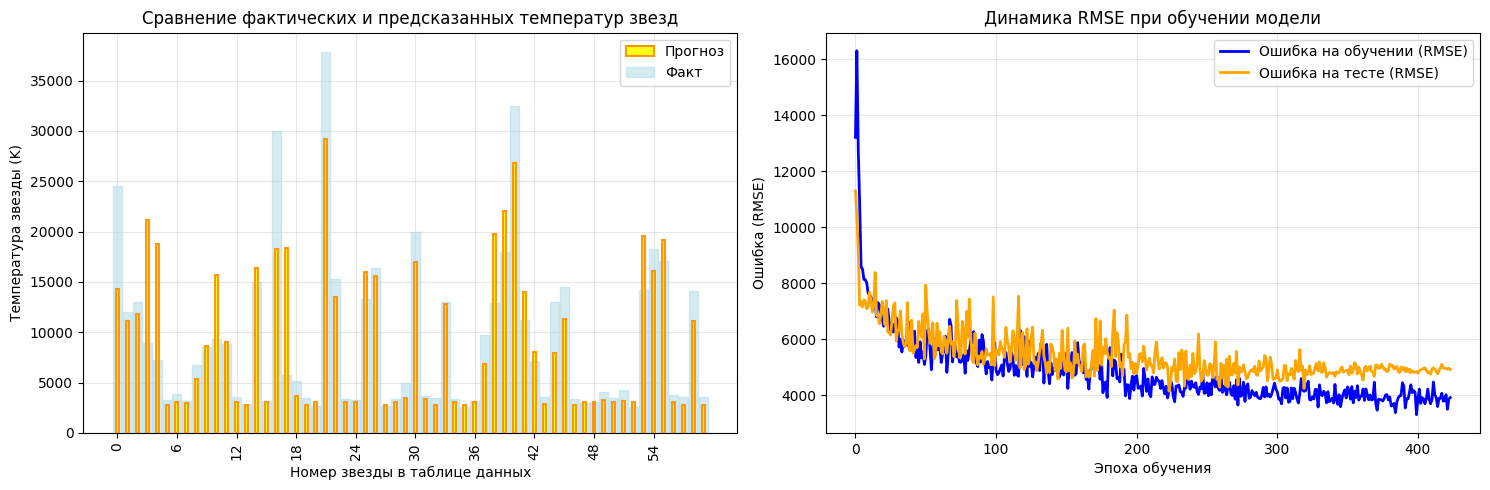

2025-11-15 15:39:53 [INFO] func: Средняя абсолютная ошибка (MAE): 2433.71 K
2025-11-15 15:39:53 [INFO] func: Среднеквадратичная ошибка (RMSE): 4142.66 K
2025-11-15 15:39:53 [INFO] func: Коэффициент детерминации (R²): 0.7207
2025-11-15 15:39:53 [INFO] func: Средняя температура: 9192.53 K
2025-11-15 15:39:53 [INFO] func: Стандартное отклонение: 7838.52 K
2025-11-15 15:39:53 [INFO] func: 
Первые 10 предсказаний:


,luminosity(_l/_lo),radius(_r/_ro),absolute_magnitude(_mv),star_type,star_color,actual_temperature,predicted_temperature,absolute_error
0,248490.00000,1134.50000,-8.24,5,blue_white,24490.0,14344.724609,10145.275391
1,0.00078,0.00920,12.13,2,blue_white,12010.0,11140.588867,869.411133
2,0.00088,0.00996,11.23,2,blue_white,12984.0,11782.685547,1201.314453
3,239000.00000,35.00000,-7.34,4,blue,8927.0,21178.179688,12251.179688
4,131000.00000,24.00000,-7.22,4,blue,7282.0,18809.744141,11527.744141
5,0.00076,0.12100,19.63,0,red,3225.0,2745.137451,479.862549
6,272000.00000,1183.00000,-9.20,5,red,3834.0,3048.868652,785.131348
7,195000.00000,17.00000,-7.22,4,red,3200.0,2943.444824,256.555176
8,1.43000,1.12000,2.41,3,white_yellow,6757.0,5357.594727,1399.405273
9,0.00050,0.01000,14.50,2,white,8500.0,8622.989258,122.989258


2025-11-15 15:39:53 [INFO] func: 
Статистика по ошибкам предсказания:


count       60.000000
mean      2433.712158
std       3380.705811
min         26.045898
25%        300.978088
50%        831.849854
75%       2855.796021
max      12663.337891
Name: absolute_error, dtype: float64

2025-11-15 15:39:53 [INFO] __main__: Лучший RMSE после оптуны: 3227.766255
2025-11-15 15:39:53 [INFO] __main__: Финальный RMSE: 4142.661222
2025-11-15 15:39:53 [INFO] __main__: MAE: 2433.712158, R²: 0.720687
2025-11-15 15:39:53 [INFO] __main__: Использованный оптимизатор: RMSprop
2025-11-15 15:39:53 [INFO] __main__: Использован планировщик: factor=0.5079940775579606, patience=48
2025-11-15 15:39:53 [INFO] __main__: Результаты финального обучения отличаются от лучших результатов Optuna
2025-11-15 15:39:53 [INFO] __main__: Лучшая модель сохранена в best_model.pth
2025-11-15 15:39:53 [INFO] __main__: Предсказания сохранены в ../result/best_model_predictions.csv


In [34]:
# все функции готовы, начинаем эксперимент
logger.info(f"Используется: {device}")
study, df_results = run_optuna_and_report(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, n_trials=N_ITER)

df_results = pd.read_csv('../result/optuna_trials_results.csv') if os.path.exists('../result/optuna_trials_results.csv') else df_results
best_result = df_results.iloc[0]

logger.info("\n=== Лучший результат ===")
logger.info(f"Лучший RMSE: {best_result['rmse']:.6f}")
for param, value in best_result.items():
    if param not in ['rmse', 'hidden_sizes']:
        logger.info(f"  {param}: {value}")

best_model, mae, rmse, r2, df_predictions = train_and_plot_best(
    study, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, X_test
)

df_predictions.to_csv('../result/best_model_predictions.csv', index=False)
logger.info("Предсказания сохранены в ../result/best_model_predictions.csv")

# Выводы

Что хотелось бы сказать в первую очередь:  
Были использованы не все возможные методы улучшения результата - по хорошему я бы еще поэкспериментировал бы с валидационной выборкой.  
Но тут у нас всего 240 строк и мы потеряем много данных для обучения.  
Также можно было бы попробовать более сложные архитектуры нейронных сетей, но опять же - мало данных и ограничения по ТЗ.  
В целом, я доволен проделанной работой и полученным результататом.  
Модель показывает приемлемое качество предсказаний температуры звезд на основе их характеристик.  

Теперь по моделям:  
1) Baseline модель - простая архитектура, минимальная настройка гиперпараметров.  
   - Модель переобучилась, без регуляризации и ранней остановки;  
   - Среднеквадратичная ошибка (RMSE): 5053.01 K
   - Коэффициент детерминации (R²): 0.5844
Т.е. результат работы модели неудовлетворительный.  

2) Улучшенная модель - архитектура таже, но добавил раннюю остановку и некоторый перебор параметров.  
   - Лучший RMSE после оптуны: 3194.938341;  
   - Финальный RMSE: ~ 3803.259260 K, примерно т.к. от эксперимента к эксперименту результат немного меняется и бывает не попадает в требования по ТЗ;    
   - Коэффициент детерминации (R²): ~ 0.764580  

Результат значительно лучше baseline модели, и удовлетворяют требования задачи.  
Да, всегда есть куда стремится, но в рамках данного проекта я считаю, что достигнут хороший результат.  
Для достижения более лучших показателей нужна выбор значительно больше.  